In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

Looking at Central Pond
Central HF Min: 27840.0
Central HF Max: 68160.0
Central HF Median: 43200.0
Central HF Mean: 43998.772023143974


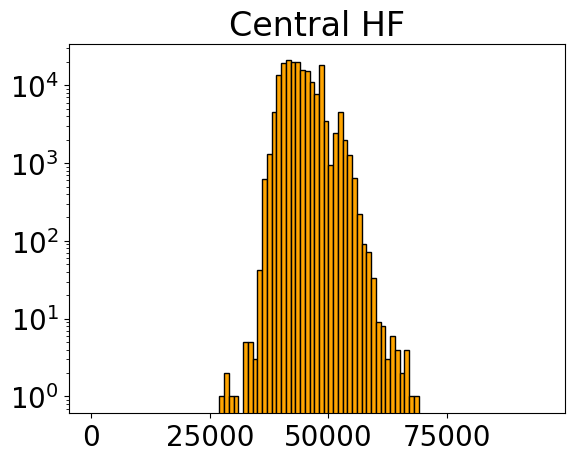

In [34]:
site_key = 'Central'
freq_key = 'HF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

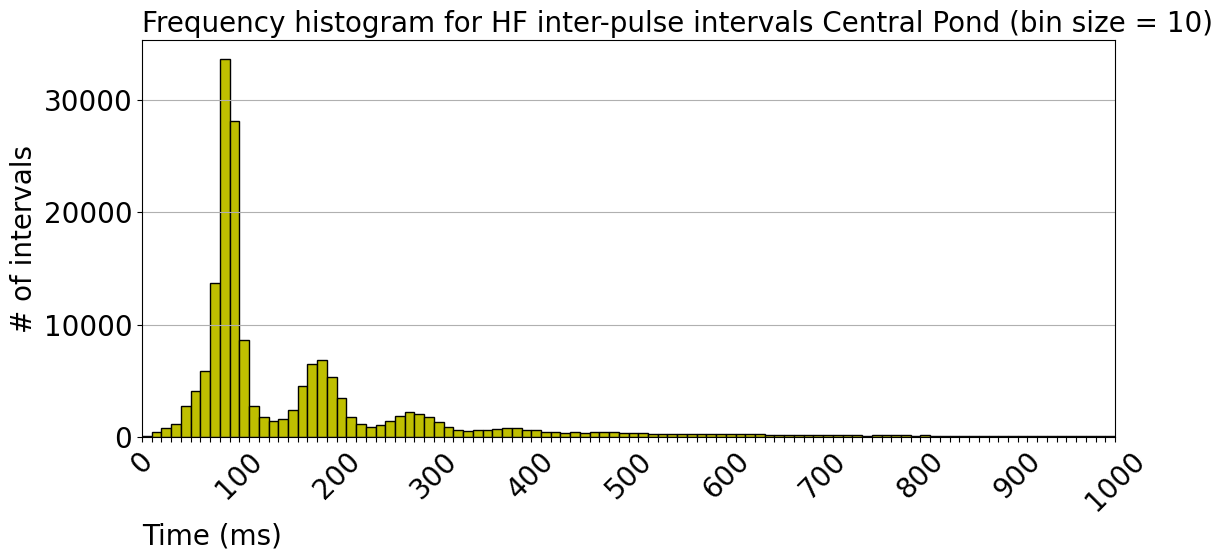

In [5]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [6]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_86126/1452210673.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)


Fagen&Young method has 1377158517 missassigned points
Slater method has 2980422 missassigned points
Sibly method has 2332391 missassigned points
Optim BCI has less misassignments than BCI? True
648030 more points assigned correctly


In [7]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.001002673292850289, intercept=10.867537949006357, rvalue=-0.8304742925634123, pvalue=1.8437211426813744e-52, stderr=4.767671403057524e-05, intercept_stderr=0.055121099812505354),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.001002673292850289,
  'num_intervals_slater': 52306097.12300638},
 {'metrics': LinregressResult(slope=-3.8886936143412463e-07, intercept=6.283265785946269, rvalue=-0.9712017261650633, pvalue=0.0, stderr=8.142579933866326e-11, intercept_stderr=0.0006495388148706843),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.8886936143412463e-07,
  'num_intervals_slater': 1377158516.6595395})

In [8]:
nlin_results

{'solution': array([1.17033003e+08, 1.56893658e-03, 1.37715852e+09, 3.88869361e-07]),
 'fast_num_intervals': 117033003.02809209,
 'fast_lambda': 0.0015689365805141972,
 'slow_num_intervals': 1377158516.7209055,
 'slow_lambda': 3.8886936144586266e-07,
 'bci': 3721.495671602757}

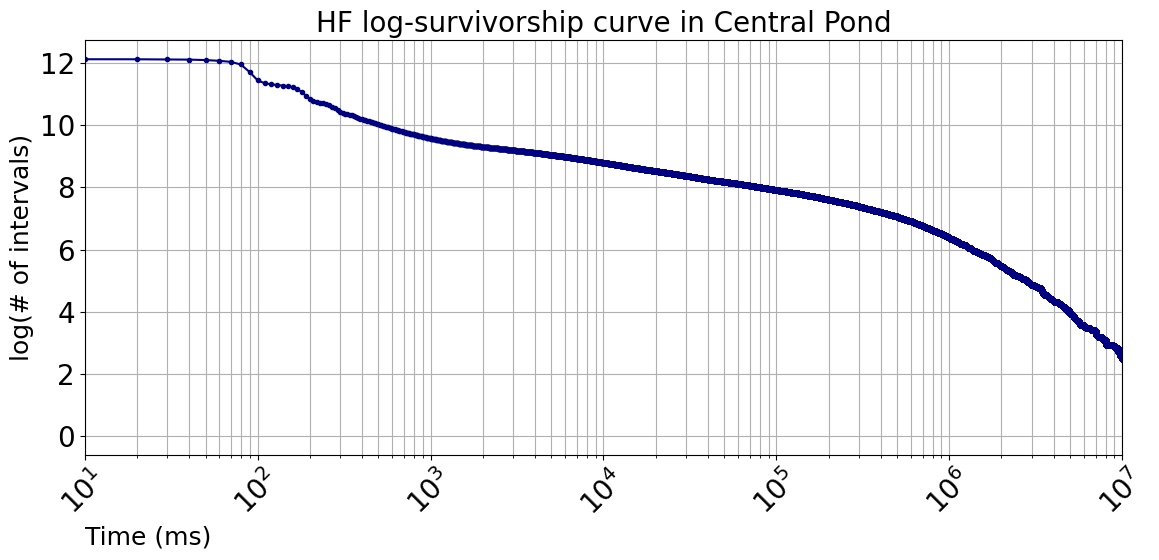

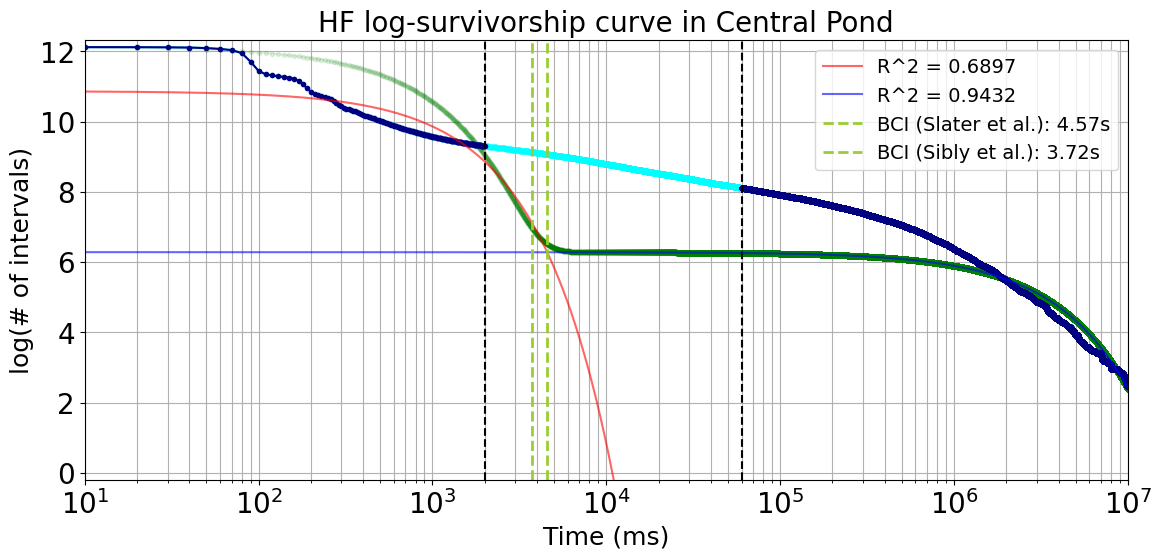

In [9]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Looking at Central Pond
Central LF Min: 16320.0
Central LF Max: 39360.0
Central LF Median: 25920.0
Central LF Mean: 25514.18212868909


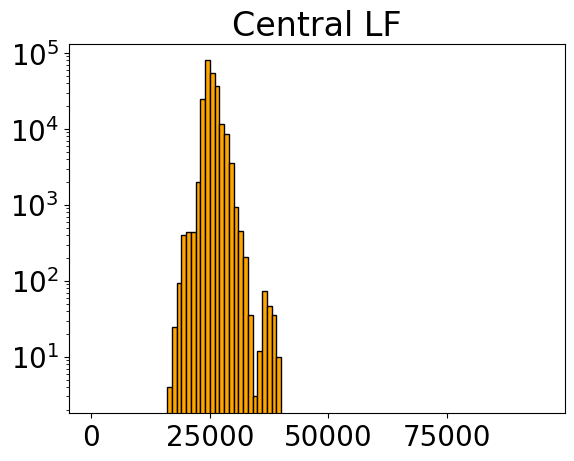

In [33]:
site_key = 'Central'
freq_key = 'LF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 1000
print(f'Looking at {fig_details["site_name"]}')
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0, dtype='object')

stat_arr = location_df.peak_frequency.astype(float)
print(f"{site_key} {freq_key} Min: {stat_arr.min()}")
print(f"{site_key} {freq_key} Max: {stat_arr.max()}")
print(f"{site_key} {freq_key} Median: {stat_arr.median()}")
print(f"{site_key} {freq_key} Mean: {stat_arr.mean()}")

plt.figure()
plt.title(f'{site_key} {freq_key}')
plt.hist(stat_arr, bins=np.arange(0, 96000, 1000), facecolor='orange', edgecolor='k')
plt.yscale('log')
plt.show()

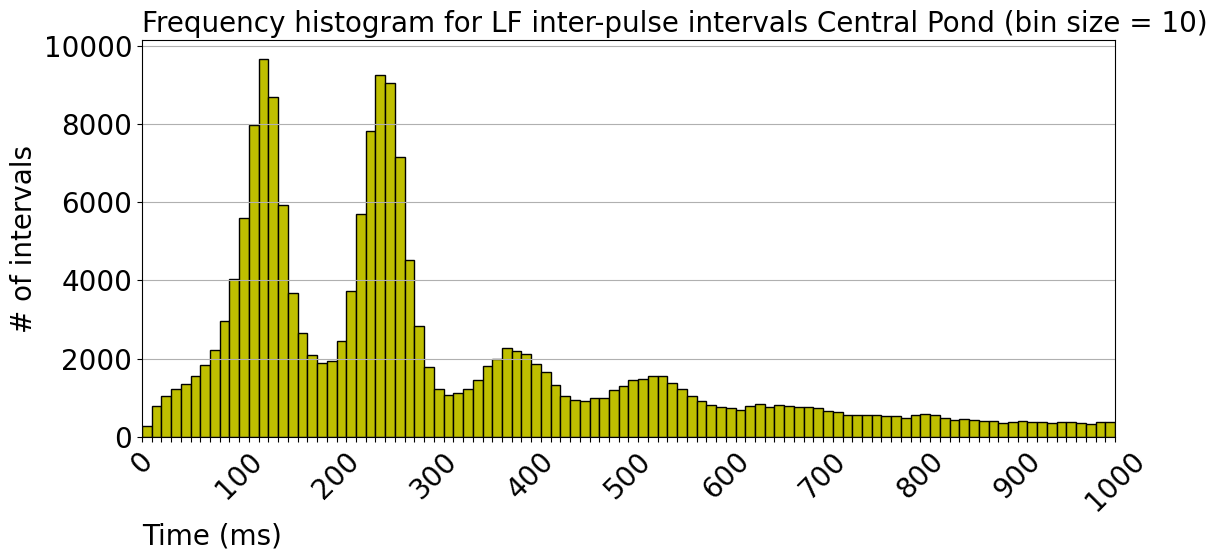

In [11]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [12]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_86126/1452210673.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)


Fagen&Young method has 1765550492 missassigned points
Slater method has 2119061 missassigned points
Sibly method has 2190000 missassigned points
Optim BCI has less misassignments than BCI? False


In [13]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0010797783504343994, intercept=11.887211753787016, rvalue=-0.9509215078164686, pvalue=2.489602945244524e-103, stderr=2.490742958441472e-05, intercept_stderr=0.028796550687511958),
  'indices': array([ True,  True,  True, ..., False, False, False]),
  'lambda': 0.0010797783504343994,
  'num_intervals_slater': 134652944.3635774},
 {'metrics': LinregressResult(slope=-1.8227321412346383e-07, intercept=5.773969273059187, rvalue=-0.9692884906115614, pvalue=0.0, stderr=2.7566865258758624e-11, intercept_stderr=0.00044935505779830057),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 1.8227321412346383e-07,
  'num_intervals_slater': 1765550491.784409})

In [14]:
nlin_results

{'solution': array([2.02458931e+08, 1.10854031e-03, 1.76555049e+09, 1.82273214e-07]),
 'fast_num_intervals': 202458931.10968652,
 'fast_lambda': 0.0011085403091441561,
 'slow_num_intervals': 1765550488.0575411,
 'slow_lambda': 1.822732139648853e-07,
 'bci': 5907.26729666335}

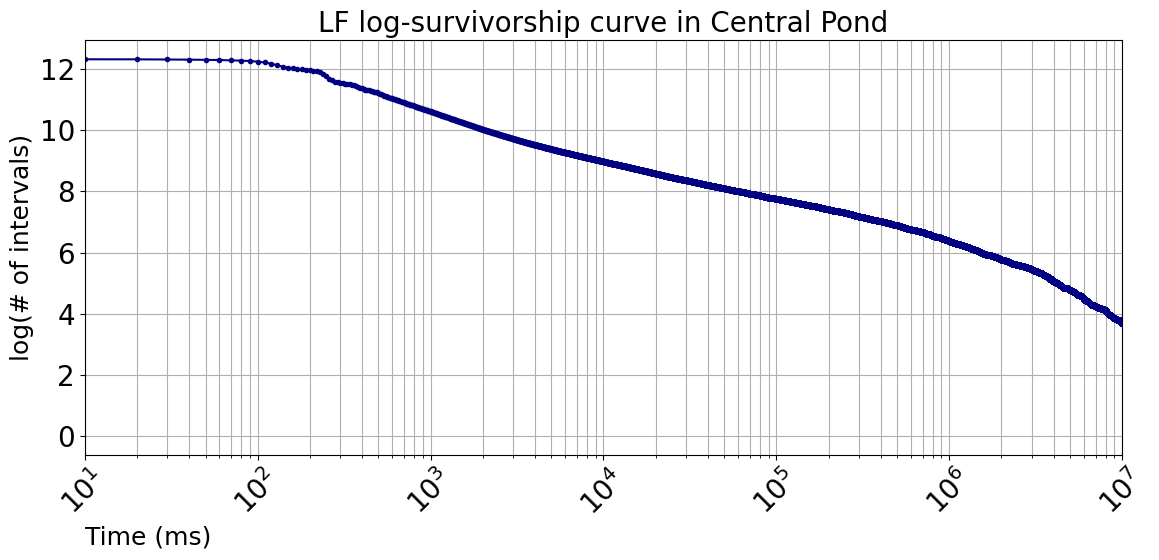

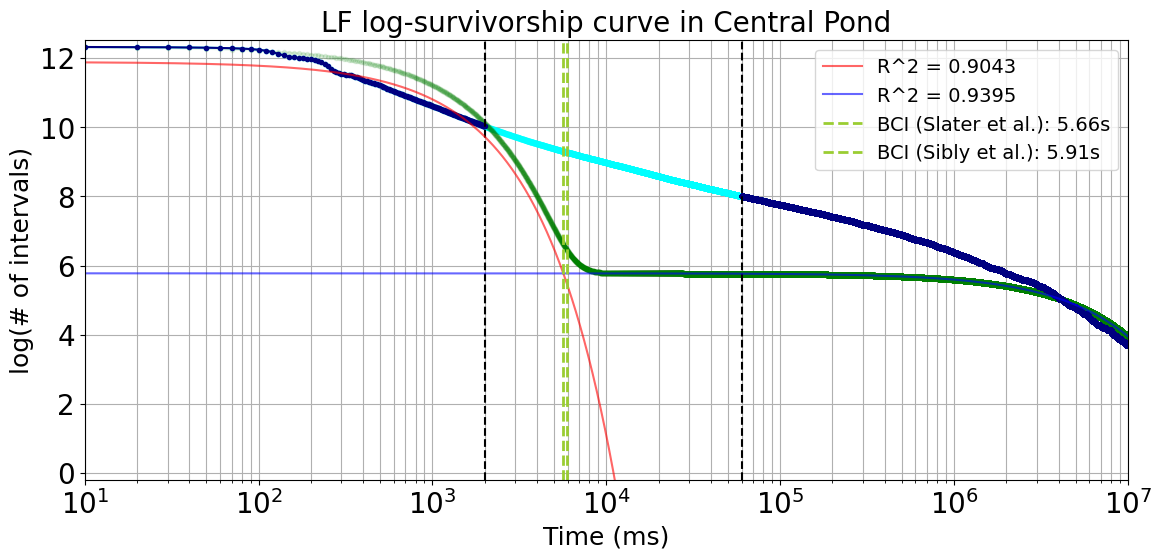

In [15]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)